### Install pymol

In [2]:
!pip install py3Dmol
!pip install gseapy

### Import Packages

In [63]:
from omero.gateway import BlitzGateway

HOST = 'tadpole.openmicroscopy.org'
USERNAME = 'user-1'
PASSWORD = ''
PORT = 4064
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT)
conn.connect()

True

### Image Details

In [64]:
image_id = 2732
image = conn.getObject("Image", image_id)
print image.getName(), image.getDescription()

P-TRE_10_R3D_D3D.dv 


### Show Rendered OMERO Image

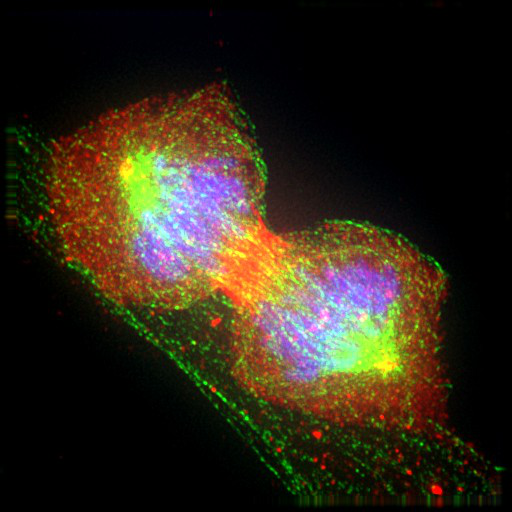

In [65]:
image.setProjection('intmax')
rendered_image = image.renderImage(0, 0)
display(rendered_image)

### Get OMERO Key-Value Annotations

In [73]:
ann = image.getAnnotation('openmicroscopy.org/omero/client/mapAnnotation')
dict_values = {}
for row in ann.getValue():
    dict_values[row[0]] = row[1]
pdb_id = dict_values[dict_values.keys()[1]]
gene_name = dict_values[dict_values.keys()[0]]

print dict_values.keys()[0] + ': ' + gene_name,',', dict_values.keys()[1] + ': ' + pdb_id

Gene Name: sec23a , pdb: 2NUT


### Display PDB structure

In [76]:
import py3Dmol

view = py3Dmol.view(query='pdb:' + pdb_id)
view.setStyle({'cartoon':{'color':'spectrum'}})
view
# display(view.png())

### Get Gene Name from map-annotation and get first 50 interactors from string 

In [74]:
# import requests
from IPython.display import Image, display
import requests
import pandas
from io import StringIO
from pandas import read_csv
def network_of_interest(gene_names, no_of_interacting_partners):
    url = 'https://string-db.org/api/image/network?identifier='
    limit = str(no_of_interacting_partners) + '&network_flavor=evidence'
    for g in gene_names:
        url = url + g  # This doesn't look like it will work

    url = url + '&limit=' + limit
    display(Image(url=url))
    
def genes_of_interest_from_string(gene_names,
                                  no_of_interacting_partners, taxonomyid):
    url = 'https://string-db.org/api/psi-mi-tab/interactionsList?identifiers='
    for g in gene_names:
        url = url + g + '%250D'
    
    url = (url + '&limit=' + str(no_of_interacting_partners) +
           '&network_flavor=evidence&species=' + taxonomyid)
    
    res = requests.get(url)
    df = read_csv(StringIO(res.text), sep='\t', header=None)
    c1 = df.loc[:, [2, 3]]
    totlist = set(list(c1[3]) + list(c1[2]))
    return list(totlist)

image = network_of_interest(gene_name, 50)
# display(Image)

gene_list = genes_of_interest_from_string([gene_name], 50, '9606')
print gene_list

['SCFD1', 'LMAN1L', 'MIA3', 'GORASP1', 'LMAN2', 'SEC23IP', 'MCFD2', 'USO1', 'SEC16A', 'SEC16B', 'SEC31B', 'SEC31A', 'TMED10', 'BET1', 'CNIH2', 'SEC23A', 'CTAGE5', 'NSF', 'GOLGA2', 'TRAPPC10', 'NAPA', 'CANX', 'NAPB', 'RAB1A', 'SEC13', 'RAB1B', 'CNIH3', 'YKT6', 'SEC24D', 'CSNK1D', 'LMAN1', 'SEC24C', 'SEC24B', 'CNIH', 'SAR1A', 'SAR1B', 'TMED2', 'SEC22C', 'SEC22A', 'COL7A1', 'TRAPPC1', 'TRAPPC3', 'TRAPPC2', 'STX5', 'TRAPPC4', 'PREB', 'TRAPPC6A', 'TRAPPC6B', 'STX17', 'GOSR2', 'SEC24A']


### Calculate enrichment profile for the list

In [75]:
# import a package for doing GO term enrichement analysis
import gseapy as gp
import pandas

pandas.set_option('display.max_colwidth', 25)
# EDIT THE NEXT LINE IF YOU WANT TO CHANGE THE DATABASE
databaseToQuery = 'GO_Cellular_Component_2017b'

print '\033[1m' + "query genes:" + '\033[0m'
enr = gp.enrichr(gene_list, gene_sets=databaseToQuery, cutoff=0.05, no_plot=False)
gsea_results= enr.res2d
gsea_results = gsea_results.sort_values('P-value', ascending=True)
display(gsea_results.head())

query genes:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,ER to Golgi transport...,21/62,4.891895e-41,7.142166e-39,1.425455e-32,2.081164e-30,-2.148044,199.378053,SEC13;SEC24B;MCFD2;SE...
1,COPII vesicle coat,18/52,2.778104e-35,2.028016e-33,7.570182e-28,5.526233e-26,-2.262712,180.041112,SEC13;SEC24B;MCFD2;SE...
2,endoplasmic reticulum...,18/84,5.887995e-31,2.865491e-29,1.359792e-24,6.617654e-23,-2.208700,153.741463,MCFD2;TMED10;STX17;RA...
8,COPII-coated ER to Go...,6/28,7.320997e-11,2.672164e-09,1.243365e-08,4.538281e-07,-1.905148,44.461757,GOLGA2;SEC23IP;SCFD1;...
3,trans-Golgi network m...,13/472,1.258090e-10,3.673622e-09,3.181103e-07,7.578010e-06,-3.417366,77.903146,RAB1A;TMED10;RAB1B;GO...
